In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report
import tensorflow as tf

In [3]:
data_dir = '/content/drive/My Drive/XRay'

In [4]:
# Splitting Data Into Training and Validation with 80:20 ratio
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100 #to randomize
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100 #to randomize
)

Found 3101 files belonging to 3 classes.
Using 2481 files for training.
Found 3101 files belonging to 3 classes.
Using 620 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [6]:
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)
base_model.trainable = True

In [7]:
#Fine tuning
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [9]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

learning_rate = 0.001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20
)

Epoch 1/20
78/78 [==============================] - 26s 304ms/step - loss: 0.0972 - accuracy: 0.9653 - val_loss: 0.6836 - val_accuracy: 0.8032
Epoch 2/20
78/78 [==============================] - 25s 301ms/step - loss: 0.0768 - accuracy: 0.9682 - val_loss: 0.1014 - val_accuracy: 0.9726
Epoch 3/20
78/78 [==============================] - 25s 303ms/step - loss: 0.0713 - accuracy: 0.9754 - val_loss: 0.0921 - val_accuracy: 0.9710
Epoch 4/20
78/78 [==============================] - 25s 303ms/step - loss: 0.0598 - accuracy: 0.9750 - val_loss: 0.1336 - val_accuracy: 0.9500
Epoch 5/20
78/78 [==============================] - 25s 301ms/step - loss: 0.0765 - accuracy: 0.9722 - val_loss: 0.1872 - val_accuracy: 0.9419
Epoch 6/20
78/78 [==============================] - 25s 302ms/step - loss: 0.0718 - accuracy: 0.9774 - val_loss: 0.2324 - val_accuracy: 0.9177
Epoch 7/20
78/78 [==============================] - 25s 301ms/step - loss: 0.0535 - accuracy: 0.9811 - val_loss: 0.1138 - val_accuracy: 0.9597

In [18]:
model.save('/content/drive/My Drive/XRay/SavedModel/')

In [19]:
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

20/20 [==============================] - 5s 181ms/step - loss: 0.0752 - accuracy: 0.9694
Test accuracy : 0.9693548679351807
Test loss: 0.07522498071193695


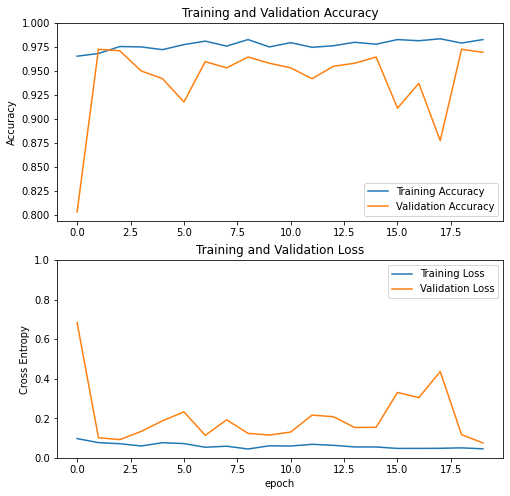

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()